<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/work/indicator/Copy_of_composite_indicator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:

def create_composite_indicator(df):
    # Select relevant features
    features = ['spread', 'new_high_new_low', 'nifty_above_dma', 'FIICash', 'DIIcash']

    # Create a copy of the dataframe with only the selected features
    df_features = df[features].copy()

    # Handle missing values (if any)
    df_features = df_features.fillna(df_features.mean())

    # Normalize the features
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_features), columns=features, index=df_features.index)

    # Assign weights to each feature (you may adjust these based on domain knowledge)
    weights = {
        'new_high_new_low': 0.2,
        'nifty_above_dma': 0.2,
        'FIICash': 0.2,
        'DIIcash': 0.2,
        'spread':0.2
        }

    # Calculate the composite indicator
    composite_indicator = sum(df_scaled[feature] * weight for feature, weight in weights.items())

    # Normalize the composite indicator to a 0-100 scale
    min_val = composite_indicator.min()
    max_val = composite_indicator.max()
    normalized_indicator = 100 * (composite_indicator - min_val) / (max_val - min_val)

    return normalized_indicator

# Assuming your dataframe is named 'df'
df = pd.read_csv('https://raw.githubusercontent.com/anirbanghoshsbi/.github.io/master/work/ml/data_for_ml.csv')  # Uncomment this line if you're reading from a CSV file
t=12
df['FIICash'] = (df['FIICash']-df['FIICash'].min())/(df['FIICash'].max()-df['FIICash'].min())
df['DIIcash'] = (df['DIIcash']-df['DIIcash'].min())/(df['DIIcash'].max()-df['DIIcash'].min())
df['DIIcash']= df['DIIcash']*-1
df['FIICash']=1*df['FIICash'].rolling(window=t).mean().fillna(0.04)
df['DIIcash']=df['DIIcash'].rolling(window=t).mean().fillna(0.04)

#df['composite_indicator'] = -(1*df['FIICash'].rolling(window=10).mean() - 2.5*df['DIIcash'].rolling(window=10).mean())
df['new_high_new_low']=df['new_high_new_low'].rolling(window=t).mean().fillna(0.04)
df['nifty_above_dma']=df['nifty_above_dma'].rolling(window=t).mean().fillna(0.04)
df['spread']= df['Close']-df['Close'].rolling(window=t).mean().fillna(0.04)
# Create the composite indicator
df['composite_indicator'] = create_composite_indicator(df)

# Interpret the indicator
df['valuation'] = pd.cut(df['composite_indicator'],
                         bins=[0, 30, 70, 100],
                         labels=['Undervalued', 'Fairly Valued', 'Overvalued'])



In [3]:
#df['FIICash'].rolling(window=20).mean().plot()

<ipython-input-4-2dfced2f39dc>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


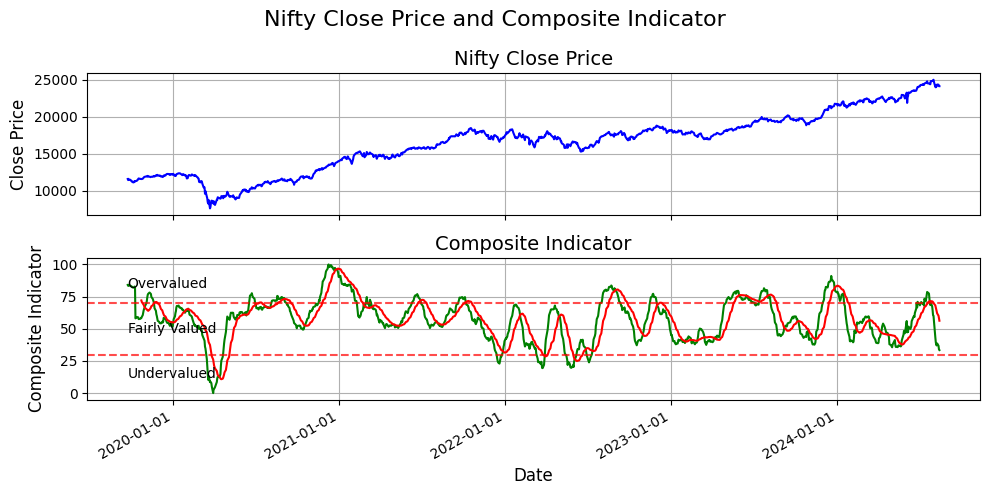

In [4]:


def plot_close_and_indicator(df):
    # Ensure the 'Date' column is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])

    # Create the figure and subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,5), sharex=True)
    fig.suptitle('Nifty Close Price and Composite Indicator', fontsize=16)

    # Plot Close price
    ax1.plot(df['Date'], df['Close'], color='blue')
    ax1.set_ylabel('Close Price', fontsize=12)
    ax1.set_title('Nifty Close Price', fontsize=14)
    ax1.grid(True)

    # Plot Composite Indicator
    ax2.plot(df['Date'], df['composite_indicator'], color='green')
    ax2.plot(df['Date'], df['composite_indicator'].rolling(window=20).mean(), color='red')
    ax2.set_ylabel('Composite Indicator', fontsize=12)
    ax2.set_title('Composite Indicator', fontsize=14)
    ax2.grid(True)

    # Add horizontal lines for valuation levels
    ax2.axhline(y=30, color='r', linestyle='--', alpha=0.7)
    ax2.axhline(y=70, color='r', linestyle='--', alpha=0.7)
    ax2.text(df['Date'].iloc[0], 15, 'Undervalued', verticalalignment='center')
    ax2.text(df['Date'].iloc[0], 50, 'Fairly Valued', verticalalignment='center')
    ax2.text(df['Date'].iloc[0], 85, 'Overvalued', verticalalignment='center')

    # Format x-axis
    plt.xlabel('Date', fontsize=12)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax2.xaxis.set_major_locator(mdates.AutoDateLocator())

    # Rotate and align the tick labels so they look better
    plt.gcf().autofmt_xdate()

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

# Assuming you have already created the dataframe 'df' with 'Close' and 'composite_indicator' columns
# If you need to read the data again:
# df = pd.read_csv('your_data.csv')
# df['composite_indicator'] = create_composite_indicator(df)  # Make sure you've defined this function

# Call the plotting function
plot_close_and_indicator(df)